In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [2]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from google.colab import drive
from tqdm.auto import tqdm
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
)

In [3]:
drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/final_emotion_model"

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

distilbert_model = AutoModelForSequenceClassification.from_pretrained(model_path)
distilbert_model.eval().to(device)

tokenizer = AutoTokenizer.from_pretrained(model_path)

**Loading Data**

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/ML/EmoTrain.csv").drop(columns=["Unnamed: 0"], errors="ignore")
val_df   = pd.read_csv("/content/drive/MyDrive/ML/EmoVal.csv").drop(columns=["Unnamed: 0"], errors="ignore")

labels = list(train_df.columns[1:])


In [6]:
train_df['label_sum'] = train_df.iloc[:, 1:].sum(axis=1)

In [7]:
valid_sums = train_df['label_sum'].value_counts()
valid_sums = valid_sums[valid_sums > 1].index  # Keep only values with at least 2 samples
train_df = train_df[train_df['label_sum'].isin(valid_sums)]

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
sample_size = 60000

# Stratified sampling
sampled_train_df, _ = train_test_split(
    train_df,
    train_size=sample_size,
    stratify=train_df['label_sum'],  # Stratify based on the sum of labels
    random_state=42
)


sampled_train_df = sampled_train_df.drop(columns=['label_sum'])

In [10]:
train_df = sampled_train_df

In [11]:
train_hf = Dataset.from_pandas(train_df)
val_hf   = Dataset.from_pandas(val_df)

In [12]:
def preprocess_data(examples):
    text = examples["text"]
    enc = tokenizer(text, padding="max_length", truncation=True, max_length=128)

    batch_size = len(text)
    num_labels = len(labels)
    label_matrix = np.zeros((batch_size, num_labels), dtype=np.float32)
    for i, lbl in enumerate(labels):
        label_matrix[:, i] = examples[lbl]
    enc["labels"] = label_matrix.tolist()
    return enc

In [13]:
train_enc = train_hf.map(preprocess_data, batched=True, remove_columns=train_hf.column_names)
val_enc   = val_hf.map(preprocess_data,   batched=True, remove_columns=val_hf.column_names)

train_enc.set_format("torch")
val_enc.set_format("torch")

train_loader = DataLoader(train_enc, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_enc,   batch_size=32, shuffle=False)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10562 [00:00<?, ? examples/s]

In [14]:
distilbert_model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [15]:
def extract_embeddings(dataloader, distilbert_model, device):
    all_embs = []
    all_lbls = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Embeddings"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_tensor = batch["labels"]  # shape: (batch_size, num_labels)


            outputs = distilbert_model.distilbert(input_ids, attention_mask=attention_mask)

            cls_emb = outputs.last_hidden_state[:, 0, :]

            all_embs.append(cls_emb.cpu())
            all_lbls.append(labels_tensor)

    all_embs = torch.cat(all_embs, dim=0)
    all_lbls = torch.cat(all_lbls, dim=0)
    return all_embs, all_lbls

In [16]:
train_embeddings, train_labels = extract_embeddings(train_loader, distilbert_model, device)
val_embeddings,   val_labels   = extract_embeddings(val_loader,   distilbert_model, device)

print("Train Embeddings shape:", train_embeddings.shape)
print("Train Labels shape:", train_labels.shape)
print("Val Embeddings shape:", val_embeddings.shape)
print("Val Labels shape:", val_labels.shape)

Extracting Embeddings:   0%|          | 0/1875 [00:00<?, ?it/s]

Extracting Embeddings:   0%|          | 0/331 [00:00<?, ?it/s]

Train Embeddings shape: torch.Size([60000, 768])
Train Labels shape: torch.Size([60000, 10])
Val Embeddings shape: torch.Size([10562, 768])
Val Labels shape: torch.Size([10562, 10])


**Embeddings**

In [17]:
from torch.utils.data import Dataset, DataLoader, random_split

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_mlp_ds = EmbeddingDataset(train_embeddings, train_labels)
val_mlp_ds   = EmbeddingDataset(val_embeddings,   val_labels)



**Multi Layer Perceptron Model**

In [18]:
import torch.nn as nn
def build_mlp(input_dim, hidden_dim, num_labels, dropout, n_layers):
    """
    Build a small MLP with variable n_layers:
      n_layers=1 -> single linear layer
      n_layers=2 -> 1 hidden layer
      n_layers=3 -> 2 hidden layers
    Adjust as you see fit.
    """
    if n_layers == 1:
        # Just output
        return nn.Sequential(
            nn.Linear(input_dim, num_labels)
        )
    elif n_layers == 2:
        # 1 hidden layer
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )
    else:
        # 2 hidden layers
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )


In [19]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


**Hyperparameter Search**

In [20]:
import optuna
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np

def tune_per_label_thresholds(logits_np, y_true_np, step=0.025):
    """
    For each label, tries thresholds to maximize that label's F1.
    Then computes micro-F1 with those thresholds.
    """
    import torch.nn as nn
    num_labels = y_true_np.shape[1]
    best_thresholds = np.zeros(num_labels, dtype=np.float32)

    sigmoid = nn.Sigmoid()
    probs_np = sigmoid(torch.from_numpy(logits_np)).numpy()

    for lbl_idx in range(num_labels):
        best_t = 0.5
        best_f1 = 0.0
        for t in np.arange(0, 1.001, step):
            preds_t = (probs_np[:, lbl_idx] >= t).astype(int)
            f1_lbl = f1_score(y_true_np[:, lbl_idx], preds_t, zero_division=0)
            if f1_lbl > best_f1:
                best_f1 = f1_lbl
                best_t = t
        best_thresholds[lbl_idx] = best_t

    # Micro-F1
    pred_matrix = []
    for lbl_idx, t in enumerate(best_thresholds):
        pred_matrix.append((probs_np[:, lbl_idx] >= t).astype(int))
    pred_matrix = np.stack(pred_matrix, axis=1)
    micro_f1 = f1_score(y_true_np, pred_matrix, average='micro', zero_division=0)
    return best_thresholds, micro_f1

def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512])
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    epochs = trial.suggest_categorical("epochs", [3, 5])
    n_layers = trial.suggest_categorical("n_layers", [1, 2, 3])

    model_mlp = build_mlp(
        input_dim=768,
        hidden_dim=hidden_dim,
        num_labels=len(labels),
        dropout=dropout,
        n_layers=n_layers
    ).to(device)

    train_loader_mlp = DataLoader(train_mlp_ds, batch_size=64, shuffle=True)
    val_loader_mlp   = DataLoader(val_mlp_ds,   batch_size=64, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_mlp.parameters(), lr=lr)

    for ep in range(epochs):
        model_mlp.train()
        total_loss = 0.0
        for Xb, Yb in train_loader_mlp:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            logits = model_mlp(Xb)
            loss = criterion(logits, Yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader_mlp)
        trial.report(avg_loss, ep)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    model_mlp.eval()
    all_val_logits = []
    all_val_true   = []
    with torch.no_grad():
        for Xb, Yb in val_loader_mlp:
            Xb, Yb = Xb.to(device), Yb.to(device)
            logits = model_mlp(Xb)
            all_val_logits.append(logits.cpu().numpy())
            all_val_true.append(Yb.cpu().numpy())

    all_val_logits = np.concatenate(all_val_logits, axis=0)
    all_val_true   = np.concatenate(all_val_true,   axis=0)

    _, micro_f1 = tune_per_label_thresholds(all_val_logits, all_val_true, step=0.05)
    return micro_f1

In [21]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
print(" Value (micro-F1):", study.best_trial.value)
print(" Params:", study.best_trial.params)
best_params = study.best_trial.params
print("Best params:", best_params)


[I 2025-02-03 18:00:34,340] A new study created in memory with name: no-name-5dd336bc-a319-4579-8fcf-b38a54333e9c
[I 2025-02-03 18:00:40,836] Trial 0 finished with value: 0.5218861147304292 and parameters: {'hidden_dim': 128, 'dropout': 0.2, 'lr': 0.0002779983275931085, 'epochs': 3, 'n_layers': 2}. Best is trial 0 with value: 0.5218861147304292.
[I 2025-02-03 18:00:46,065] Trial 1 finished with value: 0.5187674673647716 and parameters: {'hidden_dim': 256, 'dropout': 0.4, 'lr': 4.8467662844342655e-05, 'epochs': 3, 'n_layers': 1}. Best is trial 0 with value: 0.5218861147304292.
[I 2025-02-03 18:00:52,253] Trial 2 finished with value: 0.5237033306956335 and parameters: {'hidden_dim': 256, 'dropout': 0.4, 'lr': 2.2474791481079266e-05, 'epochs': 3, 'n_layers': 2}. Best is trial 2 with value: 0.5237033306956335.
[I 2025-02-03 18:00:59,314] Trial 3 finished with value: 0.520270031456544 and parameters: {'hidden_dim': 512, 'dropout': 0.2, 'lr': 0.0005914257682572653, 'epochs': 3, 'n_layers': 3

Best trial:
 Value (micro-F1): 0.529158628876688
 Params: {'hidden_dim': 256, 'dropout': 0.5, 'lr': 1.0173069289915953e-05, 'epochs': 5, 'n_layers': 2}
Best params: {'hidden_dim': 256, 'dropout': 0.5, 'lr': 1.0173069289915953e-05, 'epochs': 5, 'n_layers': 2}


**Training Loop**

Epoch 1/5
  Train Loss: 0.4539 | Val Loss: 0.3019
  Train Acc:  0.2095 | Val Acc:  0.2421
  Train F1:   0.3372 | Val F1:   0.3661

Epoch 2/5
  Train Loss: 0.2476 | Val Loss: 0.2554
  Train Acc:  0.3226 | Val Acc:  0.2939
  Train F1:   0.4681 | Val F1:   0.4187

Epoch 3/5
  Train Loss: 0.2154 | Val Loss: 0.2510
  Train Acc:  0.3748 | Val Acc:  0.3241
  Train F1:   0.5213 | Val F1:   0.4504

Epoch 4/5
  Train Loss: 0.2060 | Val Loss: 0.2515
  Train Acc:  0.4002 | Val Acc:  0.3439
  Train F1:   0.5458 | Val F1:   0.4673

Epoch 5/5
  Train Loss: 0.2027 | Val Loss: 0.2524
  Train Acc:  0.4125 | Val Acc:  0.3498
  Train F1:   0.5582 | Val F1:   0.4716



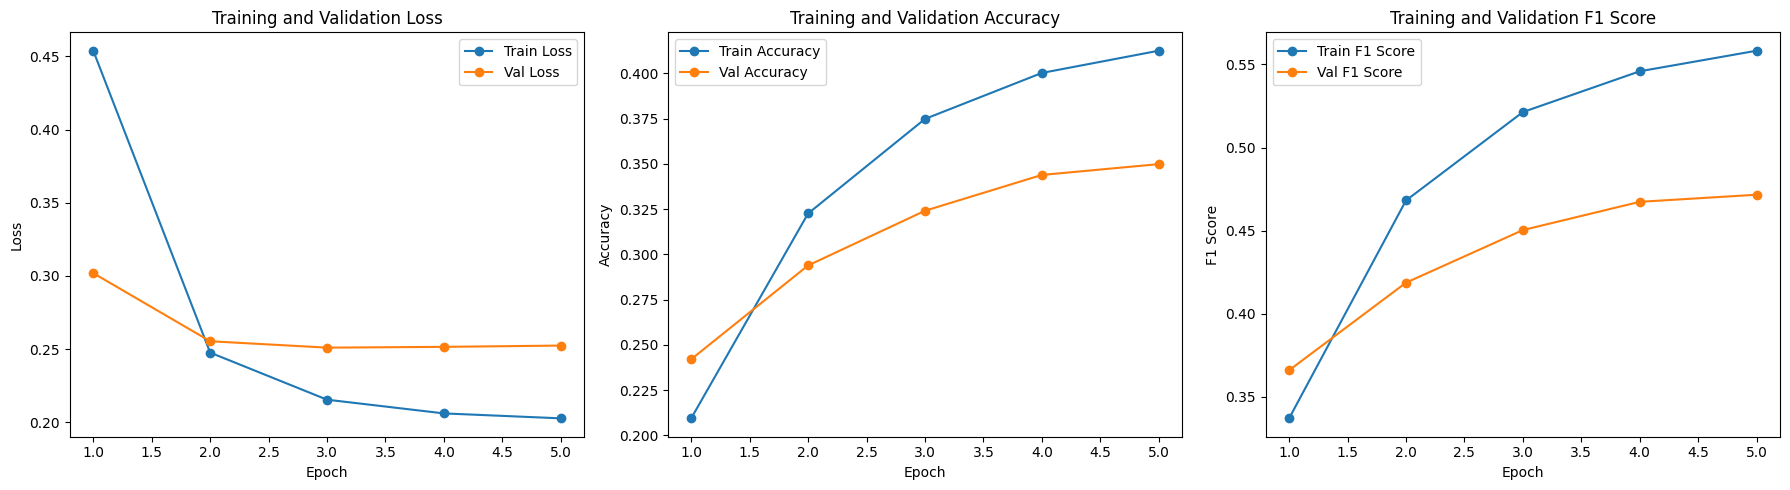

In [22]:
model_mlp_final = build_mlp(
    input_dim=768,
    hidden_dim=best_params["hidden_dim"],
    num_labels=len(labels),
    dropout=best_params["dropout"],
    n_layers=best_params["n_layers"]
).to(device)

train_loader_full = DataLoader(train_mlp_ds, batch_size=64, shuffle=True)
val_loader_full   = DataLoader(val_mlp_ds,   batch_size=64, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_mlp_final.parameters(), lr=best_params["lr"])

import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Lists to store metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []

num_epochs = best_params["epochs"]  # or set a fixed number, e.g., 10

for epoch in range(num_epochs):
    #### TRAINING PHASE ####
    model_mlp_final.train()
    running_loss = 0.0
    train_preds_list = []
    train_labels_list = []

    for Xb, Yb in train_loader_full:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        logits = model_mlp_final(Xb)
        loss = criterion(logits, Yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions using a threshold of 0.5
        preds = (torch.sigmoid(logits) >= 0.5).int().cpu().numpy()
        train_preds_list.append(preds)
        train_labels_list.append(Yb.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader_full)
    train_losses.append(avg_train_loss)

    # Concatenate predictions and labels from all batches
    train_preds = np.concatenate(train_preds_list, axis=0)
    train_labels = np.concatenate(train_labels_list, axis=0)

    # Compute training accuracy and F1 (micro-average)
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average="micro", zero_division=0)
    train_accuracies.append(train_acc)
    train_f1s.append(train_f1)

    #### VALIDATION PHASE ####
    model_mlp_final.eval()
    val_running_loss = 0.0
    val_preds_list = []
    val_labels_list = []

    with torch.no_grad():
        for Xb, Yb in val_loader_full:
            Xb, Yb = Xb.to(device), Yb.to(device)
            logits = model_mlp_final(Xb)
            loss = criterion(logits, Yb)
            val_running_loss += loss.item()

            preds = (torch.sigmoid(logits) >= 0.5).int().cpu().numpy()
            val_preds_list.append(preds)
            val_labels_list.append(Yb.cpu().numpy())

    avg_val_loss = val_running_loss / len(val_loader_full)
    val_losses.append(avg_val_loss)

    val_preds = np.concatenate(val_preds_list, axis=0)
    val_labels = np.concatenate(val_labels_list, axis=0)

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="micro", zero_division=0)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"  Train Acc:  {train_acc:.4f} | Val Acc:  {val_acc:.4f}")
    print(f"  Train F1:   {train_f1:.4f} | Val F1:   {val_f1:.4f}\n")

##############################
# Plotting the Metrics
##############################

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1s, label="Train F1 Score", marker="o")
plt.plot(epochs_range, val_f1s, label="Val F1 Score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, hamming_loss

# Evaluate the model on the validation set
model_mlp_final.eval()
all_val_logits = []
all_val_true   = []
with torch.no_grad():
    for Xb, Yb in val_loader_full:
        Xb, Yb = Xb.to(device), Yb.to(device)
        logits = model_mlp_final(Xb)
        all_val_logits.append(logits.cpu().numpy())
        all_val_true.append(Yb.cpu().numpy())

all_val_logits = np.concatenate(all_val_logits, axis=0)
all_val_true   = np.concatenate(all_val_true,   axis=0)

# Tune thresholds for each label and get the final micro-F1 score
best_thr, final_micro_f1 = tune_per_label_thresholds(all_val_logits, all_val_true, step=0.01)
print("Best per-label thresholds:", best_thr)
print(f"Final micro-F1 on Val set: {final_micro_f1:.2f}")


sig = nn.Sigmoid()
probs = sig(torch.from_numpy(all_val_logits)).numpy()
pred_bin = np.zeros_like(probs, dtype=int)
for i, t in enumerate(best_thr):
    pred_bin[:, i] = (probs[:, i] >= t).astype(int)

#Micro averaged
precision_micro  = precision_score(all_val_true, pred_bin, average='micro', zero_division=0)
recall_micro     = recall_score(all_val_true, pred_bin, average='micro', zero_division=0)
f1_micro         = f1_score(all_val_true, pred_bin, average='micro', zero_division=0)
roc_auc_micro    = roc_auc_score(all_val_true, probs, average="micro")
accuracy_overall = accuracy_score(all_val_true, pred_bin)

print("=== Final Multi-Label Metrics (Val Set) ===")
print(f"Micro-Precision: {precision_micro:.2f}")
print(f"Micro-Recall:    {recall_micro:.2f}")
print(f"Micro-F1:        {f1_micro:.2f}")
print(f"ROC-AUC (micro): {roc_auc_micro:.2f}")
print(f"Subset Accuracy: {accuracy_overall:.2f}")

#Macro averaged
precision_macro  = precision_score(all_val_true, pred_bin, average='macro', zero_division=0)
recall_macro     = recall_score(all_val_true, pred_bin, average='macro', zero_division=0)
f1_macro         = f1_score(all_val_true, pred_bin, average='macro', zero_division=0)

print(f"Macro-Precision: {precision_macro:.2f}")
print(f"Macro-Recall:    {recall_macro:.2f}")
print(f"Macro-F1:        {f1_macro:.2f}")


hloss = hamming_loss(all_val_true, pred_bin)
hamming_score_builtin = 1 - hloss
print(f"Hamming Score : {hamming_score_builtin:.2f}")


n_labels = all_val_true.shape[1]
label_accuracies = {}
for i in range(n_labels):

    label_acc = np.mean(pred_bin[:, i] == all_val_true[:, i])
    label_accuracies[f"Label {i}"] = label_acc

print("Per-label Accuracy:")
for label, acc in label_accuracies.items():
    print(f"{label}: {acc:.2f}")


Best per-label thresholds: [0.28 0.26 0.19 0.23 0.24 0.16 0.32 0.16 0.26 0.43]
Final micro-F1 on Val set: 0.53
=== Final Multi-Label Metrics (Val Set) ===
Micro-Precision: 0.48
Micro-Recall:    0.59
Micro-F1:        0.53
ROC-AUC (micro): 0.87
Subset Accuracy: 0.32
Macro-Precision: 0.47
Macro-Recall:    0.55
Macro-F1:        0.50
Hamming Score : 0.88
Per-label Accuracy:
Label 0: 0.84
Label 1: 0.93
Label 2: 0.87
Label 3: 0.90
Label 4: 0.68
Label 5: 0.90
Label 6: 0.92
Label 7: 0.98
Label 8: 0.85
Label 9: 0.93


In [24]:
import os

In [25]:
# Save MLP model and thresholds
save_path = "/content/drive/MyDrive/MLP_emotion_model"

checkpoint = {
    'model_state_dict': model_mlp_final.state_dict(),
}

# Save the checkpoint
torch.save(checkpoint, save_path + "_checkpoint.pth")
np.save(save_path + "_thresholds.npy", best_thr)

print(f"Saved model and thresholds to {save_path}*")

Saved model and thresholds to /content/drive/MyDrive/MLP_emotion_model*


**Predictions Analysis**

In [26]:
from datasets import Dataset

test_df = pd.read_csv("/content/drive/MyDrive/ML/EmoTest-sample.csv").drop(columns=["Unnamed: 0"], errors="ignore")

test_hf = Dataset.from_pandas(test_df)

test_enc = test_hf.map(preprocess_data, batched=True, remove_columns=test_hf.column_names)
test_enc.set_format("torch")

test_loader = DataLoader(test_enc, batch_size=32, shuffle=False)

test_embeddings, test_labels = extract_embeddings(test_loader, distilbert_model, device)

test_labels = test_labels.cpu().numpy()

print("Test Embeddings shape:", test_embeddings.shape)
print("Test Labels shape:", test_labels.shape)

model_mlp_final.eval()
with torch.no_grad():
    test_logits = model_mlp_final(test_embeddings.to(device))
    test_logits = test_logits.cpu().numpy()

sig = nn.Sigmoid()
probs_test = sig(torch.from_numpy(test_logits)).numpy()

pred_bin_test = np.zeros_like(probs_test, dtype=int)
for i, t in enumerate(best_thr):
    pred_bin_test[:, i] = (probs_test[:, i] >= t).astype(int)

precision_micro_test  = precision_score(test_labels, pred_bin_test, average='micro', zero_division=0)
recall_micro_test     = recall_score(test_labels, pred_bin_test, average='micro', zero_division=0)
f1_micro_test         = f1_score(test_labels, pred_bin_test, average='micro', zero_division=0)
roc_auc_micro_test    = roc_auc_score(test_labels, probs_test, average="micro")
accuracy_overall_test = accuracy_score(test_labels, pred_bin_test)
hloss = hamming_loss(test_labels, pred_bin_test)
hamming_score_builtin = 1 - hloss

print("=== Final Multi-Label Metrics (Test Set) ===")
print(f"Micro-Precision: {precision_micro_test:.2f}")
print(f"Micro-Recall:    {recall_micro_test:.2f}")
print(f"Micro-F1:        {f1_micro_test:.2f}")
print(f"ROC-AUC (micro): {roc_auc_micro_test:.2f}")
print(f"Subset Accuracy: {accuracy_overall_test:.2f}")
print(f"Hamming Score : {hamming_score_builtin:.2f}")

# Macro metrics
precision_macro_test  = precision_score(test_labels, pred_bin_test, average='macro', zero_division=0)
recall_macro_test     = recall_score(test_labels, pred_bin_test, average='macro', zero_division=0)
f1_macro_test         = f1_score(test_labels, pred_bin_test, average='macro', zero_division=0)

print(f"Macro-Precision: {precision_macro_test:.2f}")
print(f"Macro-Recall:    {recall_macro_test:.2f}")
print(f"Macro-F1:        {f1_macro_test:.2f}")

# Per-label accuracy
n_labels = test_labels.shape[1]
label_accuracies_test = {}
for i in range(n_labels):
    label_acc = np.mean(pred_bin_test[:, i] == test_labels[:, i])
    label_accuracies_test[f"Label {i}"] = label_acc

print("Per-label Accuracy (Test Set):")
for label, acc in label_accuracies_test.items():
    print(f"{label}: {acc:.2f}")



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Extracting Embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

Test Embeddings shape: torch.Size([1000, 768])
Test Labels shape: (1000, 10)
=== Final Multi-Label Metrics (Test Set) ===
Micro-Precision: 0.48
Micro-Recall:    0.61
Micro-F1:        0.54
ROC-AUC (micro): 0.87
Subset Accuracy: 0.33
Hamming Score : 0.88
Macro-Precision: 0.49
Macro-Recall:    0.55
Macro-F1:        0.50
Per-label Accuracy (Test Set):
Label 0: 0.84
Label 1: 0.94
Label 2: 0.88
Label 3: 0.88
Label 4: 0.69
Label 5: 0.92
Label 6: 0.91
Label 7: 0.97
Label 8: 0.86
Label 9: 0.93


In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

positive_counts = np.sum(test_labels, axis=1)

unique_counts = np.unique(positive_counts)

print("Performance on samples grouped by the number of positive labels (ground truth):")
for count in unique_counts:
    # Get the indices of samples with exactly 'count' positive labels
    idx = np.where(positive_counts == count)[0]
    if len(idx) == 0:
        continue

    gt_subset = test_labels[idx]
    pred_subset = pred_bin_test[idx]

    precision = precision_score(gt_subset, pred_subset, average='micro', zero_division=0)
    recall = recall_score(gt_subset, pred_subset, average='micro', zero_division=0)
    f1 = f1_score(gt_subset, pred_subset, average='micro', zero_division=0)
    subset_acc = accuracy_score(gt_subset, pred_subset)
    hloss = hamming_loss(gt_subset, pred_subset)
    hamming_score_builtin = 1 - hloss

    print(f"\nGroup: {int(count)} positive label{'s' if count != 1 else ''} (n = {len(idx)})")
    print(f"  Micro Precision: {precision:.2f}")
    print(f"  Micro Recall:    {recall:.2f}")
    print(f"  Micro F1:        {f1:.2f}")
    print(f"  Subset Accuracy: {subset_acc:.2f}")
    print(f"  Hamming Score: {hamming_score_builtin:.2f}")


Performance on samples grouped by the number of positive labels (ground truth):

Group: 0 positive labels (n = 17)
  Micro Precision: 0.00
  Micro Recall:    0.00
  Micro F1:        0.00
  Subset Accuracy: 0.06
  Hamming Score: 0.86

Group: 1 positive label (n = 839)
  Micro Precision: 0.46
  Micro Recall:    0.66
  Micro F1:        0.55
  Subset Accuracy: 0.36
  Hamming Score: 0.89

Group: 2 positive labels (n = 130)
  Micro Precision: 0.60
  Micro Recall:    0.48
  Micro F1:        0.53
  Subset Accuracy: 0.18
  Hamming Score: 0.83

Group: 3 positive labels (n = 14)
  Micro Precision: 0.78
  Micro Recall:    0.43
  Micro F1:        0.55
  Subset Accuracy: 0.14
  Hamming Score: 0.79


**Some Wrong Classifications**

In [28]:
import numpy as np

# Compute a simple error metric for each sample: number of misclassified labels
errors = np.sum(np.abs(pred_bin_test - test_labels), axis=1)

worst_indices = np.argsort(-errors)[:15]  # sort descending and take top 15

print("Top 10 worst misclassified samples (showing raw sigmoid outputs for each label):")
for idx in worst_indices:
    text = test_df.iloc[idx]["text"]
    true_labels = test_df.iloc[idx][labels].values
    pred_labels = pred_bin_test[idx]
    sample_sigmoid = probs_test[idx]
    error_count = errors[idx]

    print("=" * 50)
    print(f"Text: {text}")
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {pred_labels}")
    print(f"Number of misclassified labels: {error_count}")
    print("Sigmoid Outputs:")
    for label, sig_value in zip(labels, sample_sigmoid):
        print(f"  {label}: {sig_value:.2f}")


Top 10 worst misclassified samples (showing raw sigmoid outputs for each label):
Text: Not really if they are busy. They may not even take a break. But again if they are regularly not responding than it is probably an issue.
True Labels: [0 0 0 1 0 0 0 0 1 1]
Predicted Labels: [0 0 0 0 1 0 0 0 0 0]
Number of misclassified labels: 4.0
Sigmoid Outputs:
  praise: 0.01
  amusement: 0.00
  anger: 0.06
  disapproval: 0.15
  confusion: 0.75
  interest: 0.01
  sadness: 0.05
  fear: 0.01
  joy: 0.03
  love: 0.01
Text: The Keystone Pipeline brings in oil from Canada. As long as Canada keeps fucking over the [NAME] they'll be on good terms with the US.
True Labels: [1 0 0 0 0 0 0 0 0 1]
Predicted Labels: [0 0 1 0 1 0 0 0 0 0]
Number of misclassified labels: 4.0
Sigmoid Outputs:
  praise: 0.06
  amusement: 0.01
  anger: 0.51
  disapproval: 0.03
  confusion: 0.26
  interest: 0.01
  sadness: 0.01
  fear: 0.01
  joy: 0.06
  love: 0.01
Text: And I feel [NAME] in this Chili's tonight!
True Labels: [0 0

In [29]:
import numpy as np


positive_counts = np.sum(test_labels, axis=1)


unique_counts = np.unique(positive_counts)


print("Count frequency of labels by number of ground-truth positives:")
for c in unique_counts:
    idx = np.where(positive_counts == c)[0]
    group_size = len(idx)
    if group_size == 0:
        continue

    label_freqs = np.sum(test_labels[idx], axis=0)

    print(f"\nSamples with exactly {c} positive label(s) (n = {group_size}):")
    for label_name, freq in zip(labels, label_freqs):
        print(f"  {label_name}: {int(freq)}")


Count frequency of labels by number of ground-truth positives:

Samples with exactly 0.0 positive label(s) (n = 17):
  praise: 0
  amusement: 0
  anger: 0
  disapproval: 0
  confusion: 0
  interest: 0
  sadness: 0
  fear: 0
  joy: 0
  love: 0

Samples with exactly 1.0 positive label(s) (n = 839):
  praise: 119
  amusement: 45
  anger: 71
  disapproval: 48
  confusion: 293
  interest: 42
  sadness: 62
  fear: 21
  joy: 50
  love: 88

Samples with exactly 2.0 positive label(s) (n = 130):
  praise: 40
  amusement: 21
  anger: 25
  disapproval: 25
  confusion: 15
  interest: 22
  sadness: 18
  fear: 13
  joy: 47
  love: 34

Samples with exactly 3.0 positive label(s) (n = 14):
  praise: 8
  amusement: 2
  anger: 4
  disapproval: 2
  confusion: 2
  interest: 5
  sadness: 5
  fear: 1
  joy: 8
  love: 5


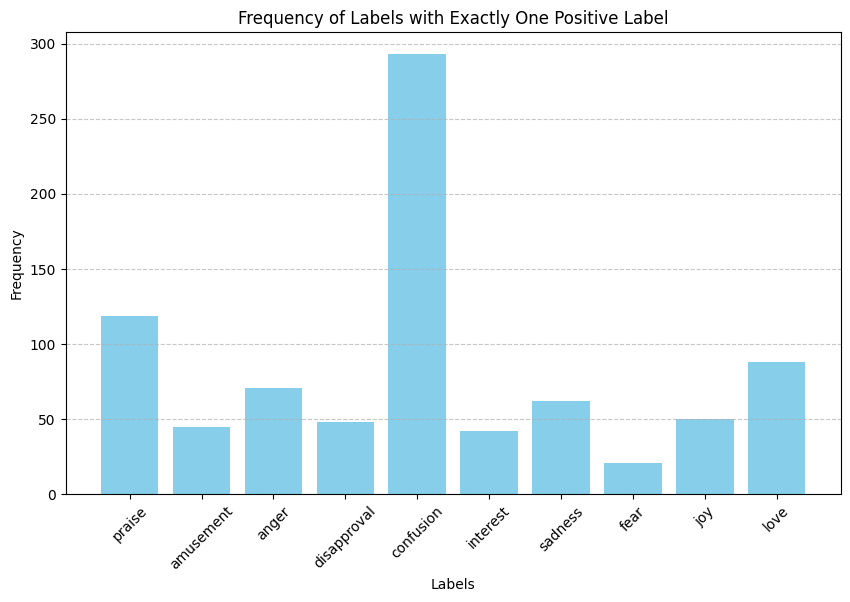

In [30]:
import matplotlib.pyplot as plt


labels = ["praise", "amusement", "anger", "disapproval", "confusion", "interest", "sadness", "fear", "joy", "love"]
frequencies = [119, 45, 71, 48, 293, 42, 62, 21, 50, 88]


plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies, color="skyblue")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Frequency of Labels with Exactly One Positive Label")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


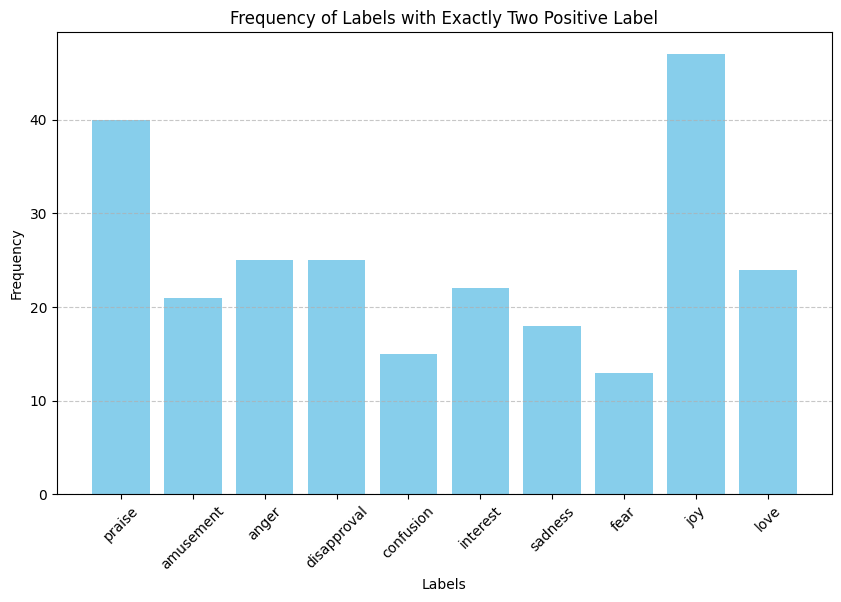

In [31]:
import matplotlib.pyplot as plt


labels = ["praise", "amusement", "anger", "disapproval", "confusion", "interest", "sadness", "fear", "joy", "love"]
frequencies = [40, 21, 25, 25, 15, 22, 18, 13, 47, 24]


plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies, color="skyblue")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Frequency of Labels with Exactly Two Positive Label")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


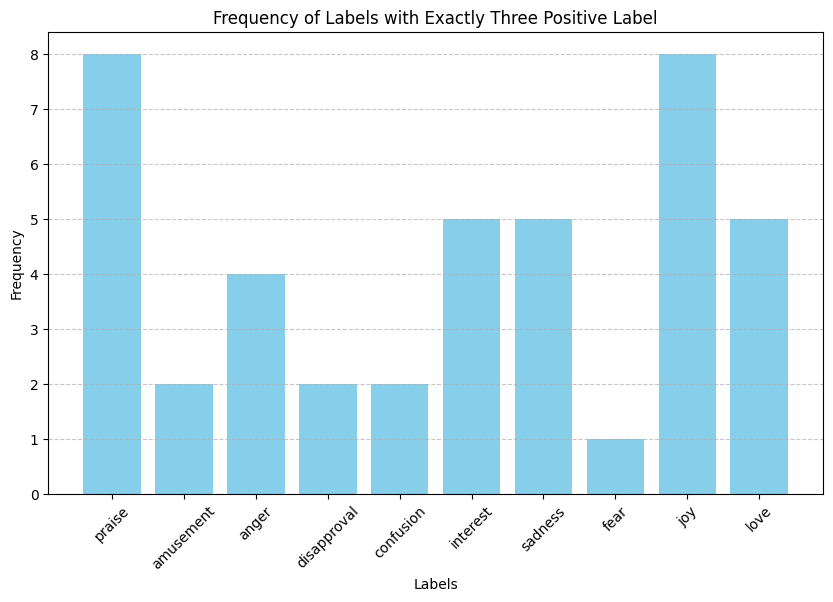

In [33]:
import matplotlib.pyplot as plt


labels = ["praise", "amusement", "anger", "disapproval", "confusion", "interest", "sadness", "fear", "joy", "love"]
frequencies = [8, 2, 4, 2, 2, 5, 5, 1, 8, 5]


plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies, color="skyblue")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Frequency of Labels with Exactly Three Positive Label")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()
